In [193]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from mysqp import NLPBuilder, value_and_jacrev, regularized_hess
from cvxopt import matrix, sparse, solvers

In [194]:
num_steps = 10
center_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.1

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])
qu, ql = jnp.full(2, 1.1), jnp.full(2, -1.1)

In [195]:
obs = Circle(center_obs, r_obs)
env = EnvSDF((obs,), safe_dist+r_robot)

In [196]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [197]:
from functools import partial

# functions
def min_dist_cost(x):
    v = to_vel(x)
    return v @ v
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(to_mat(x))

In [198]:
xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.linspace(q_init, q_goal, num_steps).flatten()

In [199]:
#build NLP problem 
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init)
nlp.add_eq_const(state_goal, q_goal)
nlp.add_eq_const(penetration, 0.)
nlp.set_state_bound(xl, xu)

In [ ]:
nlp.get_lagrangian_fn()

In [238]:
lagrangian_fn = lambda x: nlp.get_lagrangian_fn()(x[:nlp.dim], x[nlp.dim:])
get_lag_grad_hess = partial(value_and_jacrev, f=jax.grad(lagrangian_fn))
#lambda x, m: regularized_hess(jax.hessian(nlp.get_lagrangian_fn())(x, m))
get_f_val_grad = jax.value_and_grad(nlp.f)
get_g_val_grad = partial(value_and_jacrev, f=nlp.get_g())
get_h_val_grad = partial(value_and_jacrev, f=nlp.get_h())
get_merit = nlp.get_merit_fn()
get_merit_direc_deriv = nlp.get_merit_direc_deriv_fn()

is_qp_solver_initialized = False

@jdc.pytree_dataclass
class OptState:
    x: Array
    m: Array
    sigma: float
    lag_grad: Array
    lag_hess: Array
    f_val: Array
    f_grad: Array
    g_val: Array
    g_jac: Array
    h_val: Array
    h_jac: Array

    def convexify(self):
        P = matrix(np.asarray(self.lag_hess).astype(np.double))
        q = matrix(np.asarray(self.f_grad).astype(np.double))
        G = matrix(np.asarray(self.h_jac).astype(np.double))
        h = matrix(-np.asarray(self.h_val).astype(np.double))
        A = matrix(np.asarray(self.g_jac).astype(np.double))
        b = matrix(-np.asarray(self.g_val).astype(np.double))
        G = sparse(G)
        A = sparse(A)
        return P, q, G, h, A, b
    
    @jax.jit
    def max_viol(self):
        max_c_eq = jnp.linalg.norm(self.g_val, jnp.inf)
        max_c_ineq = jnp.linalg.norm(jnp.clip(self.h_val, a_min=0.), jnp.inf)
        return jnp.maximum(max_c_eq, max_c_ineq)
    
    @jax.jit
    def max_grad(self):
        return jnp.linalg.norm(self.lag_grad, jnp.inf)

def backtrack(
    state:OptState, direction: Array, 
    alpha=1., beta=0.5, gamma=0.1, max_iter=20
):
    x, sigma = state.x, state.sigma
    for i in range(max_iter):
        curr_merit = get_merit(x, sigma)
        next_merit = get_merit(x + alpha * direction, sigma)
        armijo = gamma * alpha * get_merit_direc_deriv(x, direction, sigma)
        if next_merit < curr_merit + armijo:
            break
        alpha *= beta
    return alpha

In [239]:
#state init
x = x0.copy()
m = jnp.zeros(nlp.const_dim)
sigma = 0.1

In [222]:
# function evaluation
lag_grad, lag_hess = get_lag_grad_hess(jnp.hstack([x, m]))
f_val, f_grad = get_f_val_grad(x)
g_val, g_jac = get_g_val_grad(x)
h_val, h_jac = get_h_val_grad(x)

state = OptState(x, m, sigma,
                 lag_hess, f_val, f_grad, g_val, g_jac, h_val, h_jac)

#solve qp
P, q, G, h, A, b = state.convexify()
sol = solvers.qp(P, q, G, h, A, b, 
                 options={"show_progress":True, "reltol":0.01})

direction = jnp.asarray(sol["x"]).flatten()
dual_sol = jnp.vstack(
    [jnp.asarray(sol["y"]), jnp.asarray(sol["z"])]
).flatten()

     pcost       dcost       gap    pres   dres
 0:  9.6210e-01 -7.7237e+01  8e+01  8e-16  2e-15
 1:  3.7949e-01 -4.4678e+00  5e+00  2e-16  2e-15
 2:  2.2925e-02 -2.8072e-01  3e-01  2e-16  6e-16
 3:  1.2154e-02  6.2344e-03  6e-03  1e-16  1e-16
 4:  1.2145e-02  1.2085e-02  6e-05  2e-16  1e-16
Optimal solution found.


In [223]:
# linesearch
alpha = backtrack(state, direction)
# update
x = state.x + alpha * direction
m = state.m * (1-alpha) + alpha * dual_sol
sigma = jnp.max(jnp.abs(jnp.hstack([1.01*dual_sol, sigma])))
state_prev = state

In [212]:
def draw_scene(x):
    xs = to_mat(x)
    fig, ax = plt.subplots(figsize=[5,4])
    robots = []
    for q in xs:
        circle = plt.Circle(q, r_robot, color='k')
        robots.append(circle)
        ax.add_patch(circle)
    circle = plt.Circle(center_obs, r_obs, color='r')
    ax.add_patch(circle)
    ax = plt.scatter(*xs.T)

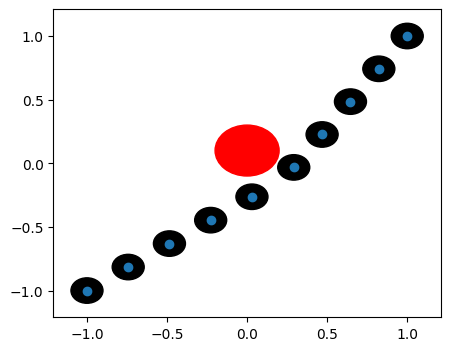

In [224]:
draw_scene(x)

In [40]:
ff = lambda x: min_dist_cost(x) + penetration(x)
ff_grad = jax.grad(ff)
ff_hess = jax.hessian(ff)

In [44]:
newton_step = - jnp.linalg.inv(ff_hess(x)) @ ff_grad(x)

In [36]:
penet_grad = jax.grad(penetration)(x)

In [33]:
env.penetration(to_mat(x)[6])

Array(0., dtype=float32, weak_type=True)

In [25]:
env.distance(to_mat(x)[0])

Array(1.286607, dtype=float32)

In [26]:
obs.distance(to_mat(x)[0])

Array(1.286607, dtype=float32)

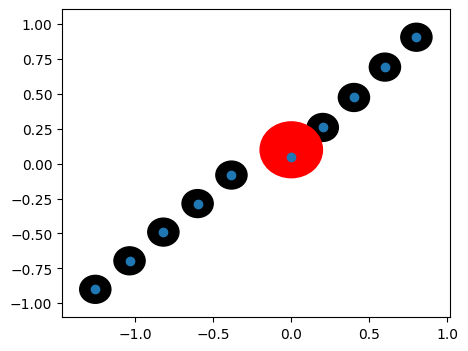

In [50]:
draw_scene(x + 0.05*newton_step)